# COVID-19 ICU Patient Analysis

Authored By: Julien Hovan

In this notebook, we perform an exploratory data analysis (EDA) of ICU patients diagnosed with COVID-19 using the MIMIC database. Our objectives are to understand the characteristics, outcomes, and treatment patterns of COVID-19 patients in the ICU setting. 

Specifically, we aim to:
- Isolate COVID-19 patients based on ICD codes.
- Analyze trends in ICU admissions over time.
- Investigate mortality rates among COVID-19 patients by age group, year group, and insurance type.
- Compare demographics and outcomes between COVID-19 and non-COVID-19 ICU patients.
- Explore prescription patterns, focusing on antiviral medications prescribed to COVID-19 patients.
- Compare patient data with external datasets, such as Medicare beneficiaries in Suffolk County.

## Table of Contents

1. [Introduction](#Introduction)
2. [Data Loading and Preprocessing](#Data-Loading-and-Preprocessing)
   - [Imports and Configurations](#Imports-and-Configurations)
   - [Data Loading](#Data-Loading)
   - [Data Preprocessing](#Data-Preprocessing)
3. [Exploratory Analysis of ICU Admissions](#Exploratory-Analysis-of-ICU-Admissions)
   - [Exploring Overall ICU Patients](#Exploring-Overall-ICU-Patients)
   - [Exploring the Disease Distribution in the ICU](#Exploring-the-Disease-Distribution-in-the-ICU)
4. [Isolating COVID-19 Patients](#Isolating-COVID-19-Patients)
   - [Defining COVID-19 ICD Codes](#Defining-COVID-19-ICD-Codes)
   - [Isolating Patients with COVID-19 ICD Codes](#Isolating-Patients-with-COVID-19-ICD-Codes)
5. [Mortality Analysis Among COVID-19 Patients](#Mortality-Analysis-Among-COVID-19-Patients)
   - [Overall Mortality Rates](#Overall-Mortality-Rates)
   - [Mortality by Age Group](#Mortality-by-Age-Group)
   - [Mortality by Insurance Type](#Mortality-by-Insurance-Type)
   - [Heatmap of Mortality Rates](#Heatmap-of-Mortality-Rates)
6. [Demographic Comparisons](#Demographic-Comparisons)
   - [Age Distribution Comparison](#Age-Distribution-Comparison)
   - [Insurance Distribution Comparison](#Insurance-Distribution-Comparison)
   - [Gender Distribution Comparison](#Gender-Distribution-Comparison)
   - [ICU Admissions Over Time](#ICU-Admissions-Over-Time)
7. [Comparison with External Data](#Comparison-with-External-Data)
   - [Medicare Beneficiaries Analysis](#Medicare-Beneficiaries-Analysis)
8. [Prescription Patterns in COVID-19 Patients](#Prescription-Patterns-in-COVID-19-Patients)
   - [Loading Prescription Data](#Loading-Prescription-Data)
   - [Exploring Common Medications](#Exploring-Common-Medications)
   - [Antiviral Medication Analysis](#Antiviral-Medication-Analysis)
9. [Conclusions](#Conclusions)
   - [Summary of Findings](#Summary-of-Findings)
   - [Limitations](#Limitations)
   - [Recommendations](#Recommendations)

## Intro

The COVID-19 pandemic has placed unprecedented strain on healthcare systems worldwide, with Intensive Care Units (ICUs) being at the forefront of this crisis. As the most severe cases of COVID-19 often require intensive care, the capacity and utilization of ICUs have become critical indicators of the pandemic's impact on hospitals. During peak periods, many hospitals across the United States faced challenges in managing ICU capacity, leading to the transfer of patients and resources between states to accommodate the surge in demand.

This analysis focuses on ICU patients diagnosed with COVID-19 to provide insights into the characteristics, outcomes, and treatment patterns of these critical cases. By examining ICU data, we aim to understand the broader implications of COVID-19 on hospital operations and patient care. It is important to note that while ICUs represent the most severe cases, there are likely many individuals admitted to hospitals with COVID-19 who were not diagnosed or tested, as well as those with less severe symptoms who did not require intensive care.

Through this study, we hope to shed light on the challenges faced by ICUs during the pandemic and contribute to the ongoing efforts to improve healthcare system resilience in the face of future public health emergencies.

## Data Loading and Preprocessing

### Imports and Configurations

In [185]:
# for developmental purposes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [186]:
# Data manipulation and visualization libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Import the Preprocessor class and Utility functions
from config import FILE_PATHS
from preprocessing.preprocessor import Preprocessor
from preprocessing.utils import Utils
from math import pi

# for interactive displays
from preprocessing.utils import Utils

# Initialize the preprocessor class
preprocessor = Preprocessor(file_paths=FILE_PATHS)

#### Data Loading

Load patient, admissions, ICU stays, and prescription data from Processed Data Folder

In [187]:
patients_df = pd.read_pickle('../Processed_Data/patients.pkl')
admission_df = pd.read_pickle('../Processed_Data/admissions.pkl')
icu_stays_df = pd.read_pickle('../Processed_Data/icu_stays.pkl')


Utils.display_dataframes([patients_df, admission_df, icu_stays_df], ['Patients', 'Admissions', 'ICU Stays'])

Let's load thte processed hospital diagnosis table, which has linked all ICD codes to their corresponding disease cateogries and subcategories.

This will allow us to perform a more detailed analysis of the COVID-19 diagnoses and their impact on patient outcomes.

In [188]:
hosp_diagnosis_cause_df = pd.read_pickle("../Processed_Data/hosp_diagnosis.pkl")
# lets take a look at a sample of the data
hosp_diagnosis_cause_df.sample(5, random_state=42)

,subject_id,hadm_id,icd_code,icd_version,category_code,category,subcategory
2727769,19390719,29701453,4019,9,401,Circulatory System,Hypertensive Disease
4813771,15493609,27397414,Y92230,10,Y92,External Causes,Supplementary factors related to causes of mor...
1509173,15200895,24824236,44024,9,440,Circulatory System,"Diseases Of Arteries, Arterioles, And Capillaries"
1385006,14786669,24737993,V1251,9,V12,Other,Other
5236415,16711794,27107405,Z950,10,Z95,Other,Other


### Data Preprocessing

Clean and merge the datasets for analysis

In [189]:
# merge on subject_id and hadm_id
diagnosis_icu_df = hosp_diagnosis_cause_df.merge(icu_stays_df, on=['subject_id', 'hadm_id'], how='inner')
# merge with patients table to get demographics
diagnosis_icu_df = diagnosis_icu_df.merge(patients_df, on='subject_id', how='inner')
# merge with admission for insurance data
diagnosis_icu_df = diagnosis_icu_df.merge(admission_df.drop('is_dead', axis=1), on=['subject_id', 'hadm_id'], how='inner')

# save to pickle file
diagnosis_icu_df.to_pickle("../Processed_Data/diagnosis_icu_df.pkl")

diagnosis_icu_df.head(3)

,subject_id,hadm_id,icd_code,icd_version,category_code,category,subcategory,stay_id,first_careunit,last_careunit,...,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,admission_los_hours
0,10000032,29079034,45829,9,458,Circulatory System,"Diseases Of Veins And Lymphatics, And Other Di...",39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),...,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,White/European Descent,2180-07-23 05:54:00,2180-07-23 14:00:00,0,53.333333
1,10000032,29079034,07044,9,070,Other,Other,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),...,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,White/European Descent,2180-07-23 05:54:00,2180-07-23 14:00:00,0,53.333333
2,10000032,29079034,7994,9,799,Symptoms & Abnormal Findings,Ill-Defined And Unknown Causes Of Morbidity An...,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),...,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,White/European Descent,2180-07-23 05:54:00,2180-07-23 14:00:00,0,53.333333


## Exploratory Analysis of ICU Admissions 

### Exploring Overall ICU Patients

Lets get an idea of the ICU patient population from the years 2008 to 2019. We aim to analyze demographics and admission data of ICU patients

In [190]:
# ...

### Exploring the Disease distribution in the ICU

#### Frequency of Respiratory Diseases

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_13222/1129412612.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  respiratory_counts = respiratory_df.groupby('anchor_year_group').size()


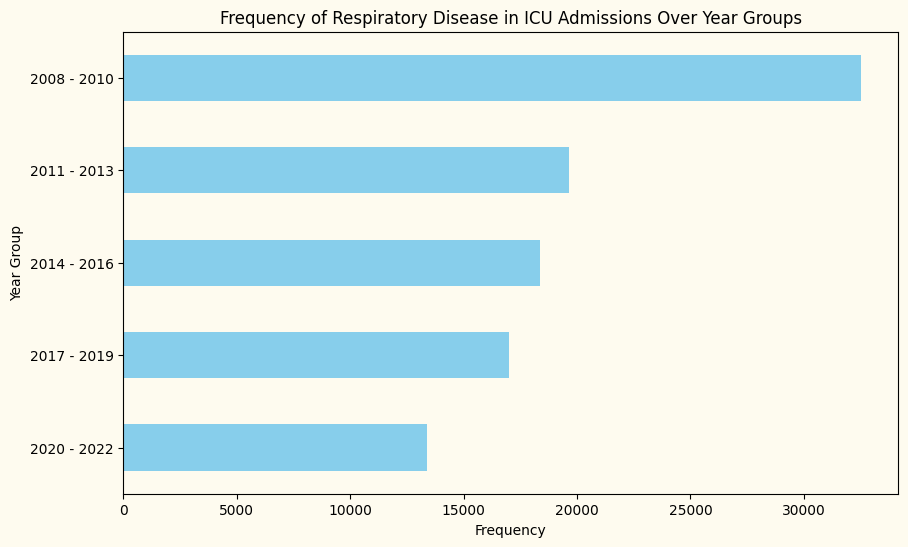

In [191]:
def plot_respiratory_disease_frequency(diagnosis_icu_df):
    # Filter the dataframe for respiratory disease
    respiratory_df = diagnosis_icu_df[diagnosis_icu_df['category'] == 'Respiratory System']

    # Group by anchor_year_group and count occurrences
    respiratory_counts = respiratory_df.groupby('anchor_year_group').size()

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.patch.set_facecolor('#fefbef')
    ax.set_facecolor('#fefbef')
    respiratory_counts.sort_values().plot(kind='barh', color='skyblue', ax=ax)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Year Group')
    ax.set_title('Frequency of Respiratory Disease in ICU Admissions Over Year Groups')
    plt.show()

# Call the function
plot_respiratory_disease_frequency(diagnosis_icu_df)

## Isolating Covid-19 Patients
 
**Confirmed Cases:**
A confirmed COVID-19 hospital encounter is defined as any listed ICD–10–CM diagnosis code of B97.29 and/or U07.1.
- Prior to April 1, 2020, CDC guidance stated to code a confirmed COVID-19 hospital encounter as B97.29.
- On April 1, 2020, the guidance changed to code confirmed COVID-19 hospital encounters as U07.1.
- The figure shows the percentage of hospital encounters coded with a B97.29 and/or U07.1 code.
 
**Suspected Cases:**
A suspected COVID-19 hospital encounter in 2020 is defined by an ICD–10–CM code of contact with and (suspected) exposure to other viral communicable diseases (Z20.828).
- In 2021, it is defined by an ICD-10-CM code of contact with and (suspected) exposure to COVID-19 (Z20.822).
- Additionally, suspected encounters do not contain any confirmed codes.
- In early versions (March 18, 2020 – December 29, 2020) of this figure, suspected COVID-19 was defined by the ICD-10-CM code for COVID-19, virus not identified (U07.2) or coronavirus infection, unspecified (B34.2).
- The earlier version also included potential COVID-19 hospital encounters as having an ICD–10–CM code for pneumonia (J12.89), acute bronchitis (J20.8, J40), lower respiratory infection (J22, J98.8), or Acute Respiratory Distress Syndrome (J80).
- The potential portion of the definition was removed for this update due to revised CDC guidance for coding suspected COVID-19.
 
**Sources:**
- [CDC Hospital Encounters by Week](https://www.cdc.gov/nchs/covid19/nhcs/hospital-encounters-by-week.htm)
- [JAMA Article](https://jamanetwork.com/journals/jama/fullarticle/2774396)

#### Defining COVID-10 ICD Codes

Identify ICD codes corresponding to confirmed, suspected, and potential COIVD-19 cases


In [192]:
# Define COVID-19 related ICD-10-CM codes
covid_codes = ['U071', 'U072', 'B9729', 'Z20828', 'Z20822', 'J1289', 'J208', 'J40', 'J22', 'J988', 'J80']

# Create a regex pattern to match the codes at the start of the string
covid_pattern = '^(' + '|'.join(covid_codes) + ')'

#### Isolating Patients with COVID-19 ICD codes

In [215]:
def get_covid_diagnoses(diagnosis_icu_df):
    """
    Isolate and categorize COVID-19 diagnoses from the given ICU diagnosis dataframe.

    Parameters:
    diagnosis_icu_df (pd.DataFrame): DataFrame containing ICU diagnosis data with an 'icd_code' column.

    Returns:
    pd.DataFrame: A DataFrame containing only the COVID-19 related diagnoses with an additional 'covid_category' column.
                  The 'covid_category' column categorizes the diagnoses into 'Confirmed', 'Suspected', 'Potential', and 'Other'.
    """

    # Filter the dataframe for COVID-19 diagnoses using the defined codes with contains
    covid_diagnoses = diagnosis_icu_df[diagnosis_icu_df['icd_code'].str.contains(covid_pattern, regex=True, na=False)].copy()

    # Create a new column to categorize the diagnosis
    covid_diagnoses.loc[:, 'covid_category'] = 'Other'
    covid_diagnoses.loc[covid_diagnoses['icd_code'].str.contains('^(U071|U072|B9729)', regex=True, na=False), 'covid_category'] = 'Confirmed'
    covid_diagnoses.loc[covid_diagnoses['icd_code'].str.contains('^(Z20828|Z20822)', regex=True, na=False), 'covid_category'] = 'Suspected'
    covid_diagnoses.loc[covid_diagnoses['icd_code'].str.contains('^(J1289|J208|J40|J22|J988|J80)', regex=True, na=False), 'covid_category'] = 'Potential'

    # Create age groups
    covid_diagnoses.loc[:, 'age_group'] = pd.cut(
        covid_diagnoses['anchor_age'],
        bins=[0, 25, 45, 65, 75, 85, 100],
        labels=['<25', '25-44', '45-64', '65-74', '75-84', '85+']
    )
    
    return covid_diagnoses

covid_diagnoses = get_covid_diagnoses(diagnosis_icu_df)
# we can save to use in other notebooks
covid_diagnoses.to_pickle("../Processed_Data/covid_diagnoses.pkl")

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_13222/3482459207.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  covid_diagnoses = diagnosis_icu_df[diagnosis_icu_df['icd_code'].str.contains(covid_pattern, regex=True, na=False)].copy()
/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_13222/3482459207.py:18: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  covid_diagnoses.loc[covid_diagnoses['icd_code'].str.contains('^(U071|U072|B9729)', regex=True, na=False), 'covid_category'] = 'Confirmed'
/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_13222/3482459207.py:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  covid_diagnoses.loc[covid_diagnoses['icd_code'].str.contains('^(Z20828|Z20822)', regex

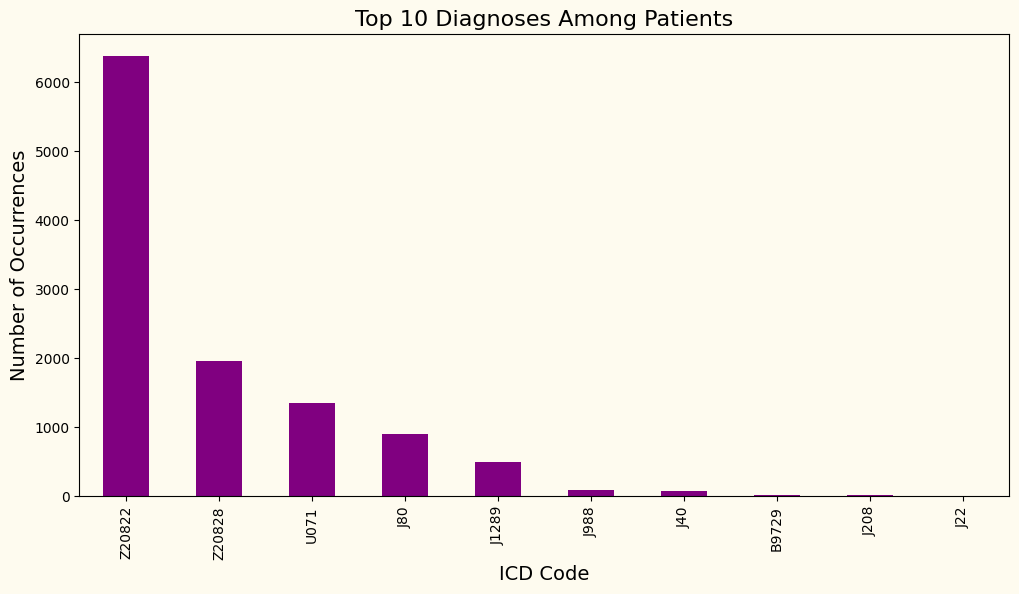

In [214]:
def plot_top_diagnoses(covid_diagnoses):
    """
    Plot the top 10 diagnoses among patients.

    Parameters:
    covid_diagnoses (pd.DataFrame): DataFrame containing COVID-19 related diagnoses with an 'icd_code' column.
    """
    # Count of diagnoses
    top_diagnoses = covid_diagnoses['icd_code'].value_counts().nlargest(10)

    # Bar plot of top diagnoses
    plt.figure(figsize=(12, 6), facecolor='#fefbef')
    ax = plt.gca()
    ax.set_facecolor('#fefbef')
    top_diagnoses.plot(kind='bar', color='purple')
    plt.title('Top 10 Diagnoses Among Patients', fontsize=16)
    plt.xlabel('ICD Code', fontsize=14)
    plt.ylabel('Number of Occurrences', fontsize=14)
    plt.show()

plot_top_diagnoses(covid_diagnoses)

We can see that the most numerous codes present are Z20822 and Z20828, which correspond to suspected COVID-19 infections, ie the physican has suspected the patient has COVID-19 infection, but no test was performed to confirm the diagnosis.

#### Trend Analysis 
 
Lets Analyze the number of admissions with COVID-19 ICD codes

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_13222/2242869873.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  covid_counts = covid_diagnoses.groupby(['anchor_year_group', 'covid_category']).size().unstack(fill_value=0)


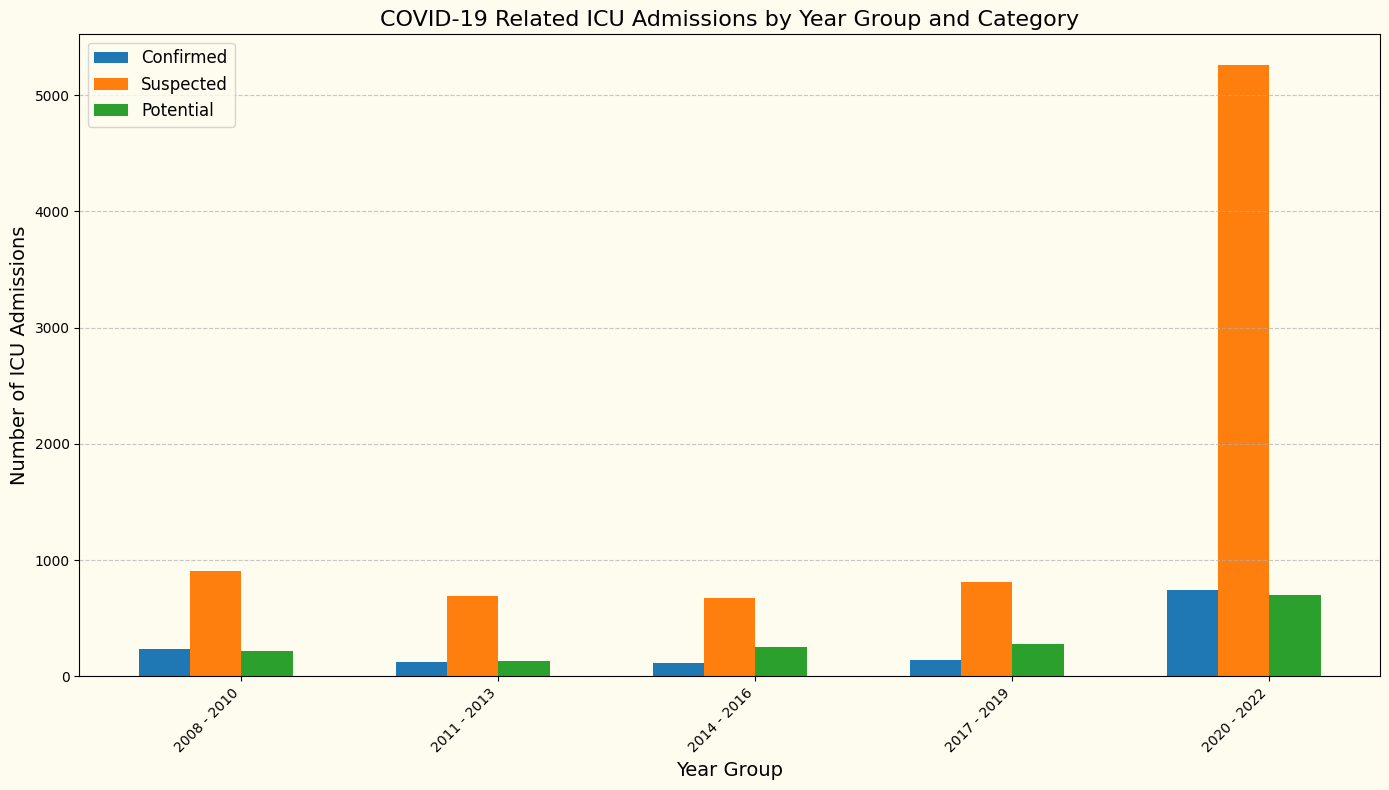

In [195]:
def plot_covid_admissions_by_year_group(covid_diagnoses):
    """
    Plot the number of COVID-19 related ICU admissions by year group and category.

    Parameters:
    covid_diagnoses (pd.DataFrame): DataFrame containing COVID-19 related diagnoses with 'anchor_year_group' and 'covid_category' columns.
    """
    # Group by anchor_year_group and covid_category, then count occurrences
    covid_counts = covid_diagnoses.groupby(['anchor_year_group', 'covid_category']).size().unstack(fill_value=0)

    # Sort the year groups in chronological order
    covid_counts = covid_counts.sort_index(key=lambda x: x.str.split(' - ').str[0].astype(int))

    # Plotting
    plt.figure(figsize=(14, 8), facecolor='#fefbef')
    ax = plt.gca()
    ax.set_facecolor('#fefbef')
    bar_width = 0.2
    index = np.arange(len(covid_counts.index))

    for i, category in enumerate(['Confirmed', 'Suspected', 'Potential']):
        if category in covid_counts.columns:
            plt.bar(index + i*bar_width, covid_counts[category], bar_width, label=category)

    plt.xlabel('Year Group', fontsize=14)
    plt.ylabel('Number of ICU Admissions', fontsize=14)
    plt.title('COVID-19 Related ICU Admissions by Year Group and Category', fontsize=16)
    plt.xticks(index + bar_width * 1.5, covid_counts.index, rotation=45, ha='right')
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


plot_covid_admissions_by_year_group(covid_diagnoses)

## Mortality Analysis Among COVID-19 Patients

#### Overall Mortality Rates

- Calculate mortality rates for COVID-19 patients across year groups

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_13222/2279512239.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mortality_data = covid_diagnoses.groupby('anchor_year_group').agg({


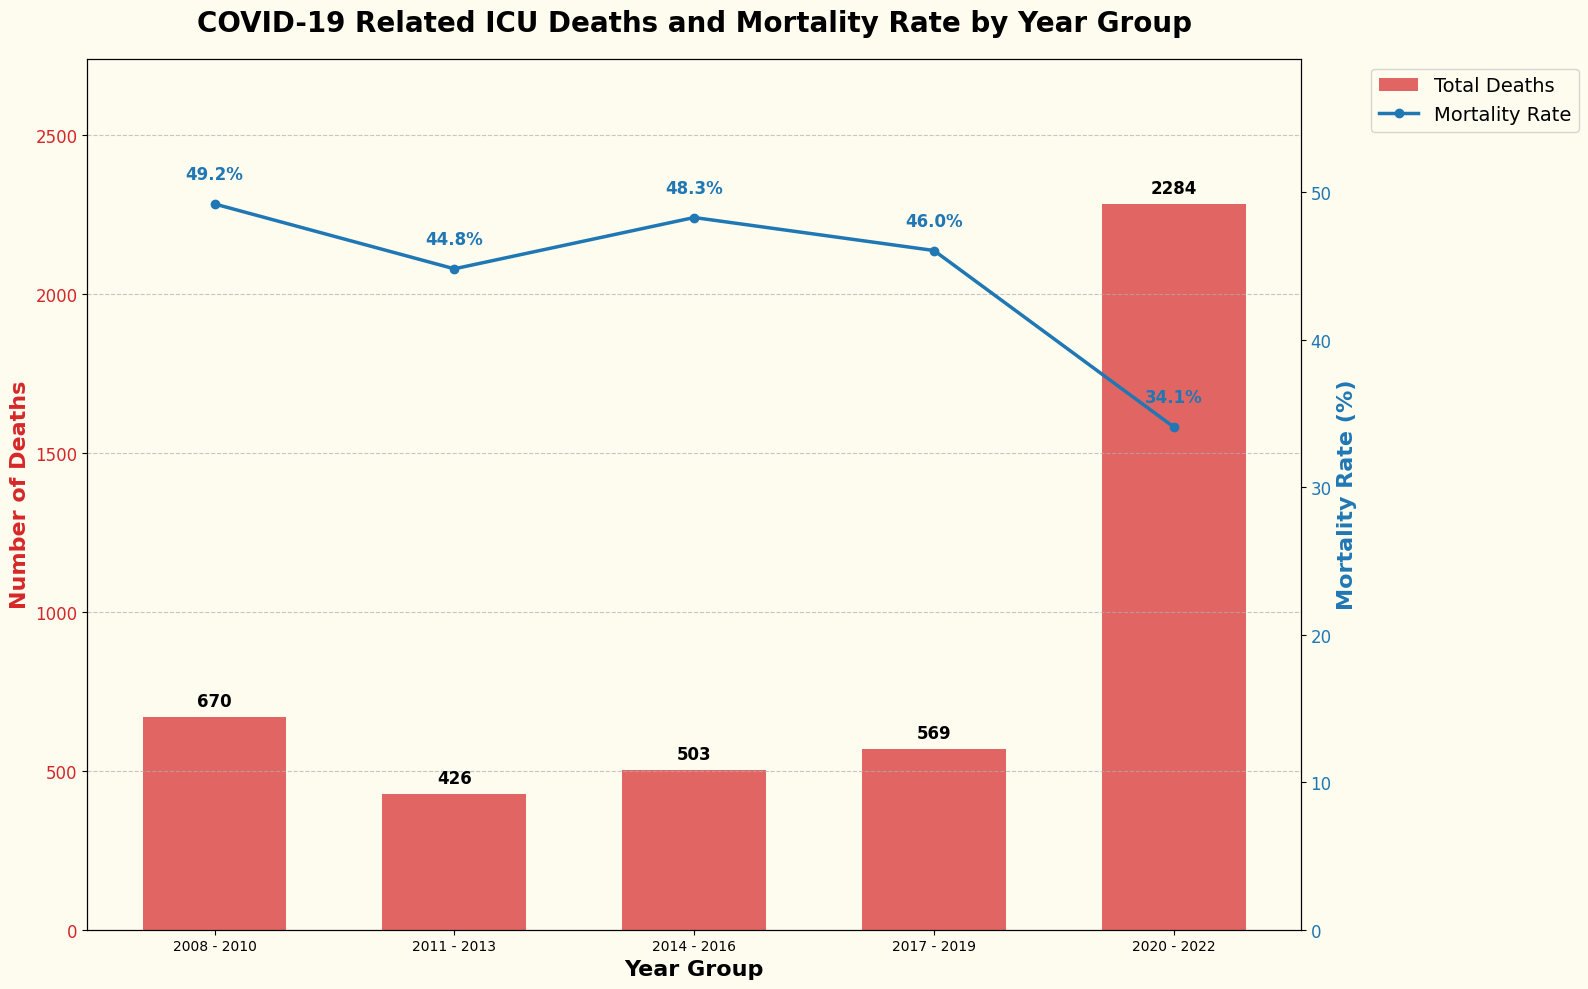

In [196]:
def plot_mortality_by_year_group(covid_diagnoses):
    """
    Plot the number of COVID-19 related ICU deaths and mortality rate by year group.

    Parameters:
    covid_diagnoses (pd.DataFrame): DataFrame containing COVID-19 related diagnoses with 'anchor_year_group' and 'is_dead' columns.
    """
    # Group by anchor_year_group and calculate total deaths and mortality rate
    mortality_data = covid_diagnoses.groupby('anchor_year_group').agg({
        'is_dead': ['count', 'sum']
    })

    mortality_data.columns = ['total_patients', 'deaths']
    mortality_data['mortality_rate'] = mortality_data['deaths'] / mortality_data['total_patients'] * 100

    # Sort the year groups in chronological order
    mortality_data = mortality_data.sort_index(key=lambda x: x.str.split(' - ').str[0].astype(int))

    # Plotting
    fig, ax1 = plt.subplots(figsize=(16, 10), facecolor='#fefbef')
    ax1.set_facecolor('#fefbef')

    # Bar plot for total deaths
    bars = ax1.bar(mortality_data.index, mortality_data['deaths'], 
                   alpha=0.7, color='#d62728', label='Total Deaths', width=0.6)
    ax1.set_xlabel('Year Group', fontsize=16, weight='bold')
    ax1.set_ylabel('Number of Deaths', fontsize=16, weight='bold', color='#d62728')
    ax1.tick_params(axis='y', labelcolor='#d62728', labelsize=12)
    ax1.set_ylim(0, mortality_data['deaths'].max() * 1.2)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Line plot for mortality rate
    ax2 = ax1.twinx()
    line = ax2.plot(mortality_data.index, mortality_data['mortality_rate'], 
                   color='#1f77b4', marker='o', linewidth=2.5, label='Mortality Rate')
    ax2.set_ylabel('Mortality Rate (%)', fontsize=16, weight='bold', color='#1f77b4')
    ax2.tick_params(axis='y', labelcolor='#1f77b4', labelsize=12)
    ax2.set_ylim(0, mortality_data['mortality_rate'].max() * 1.2)

    # Title and legend
    plt.title('COVID-19 Related ICU Deaths and Mortality Rate by Year Group', fontsize=20, weight='bold', pad=20)
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(handles=handles1 + handles2, labels=labels1 + labels2, 
               loc='upper left', fontsize=14, bbox_to_anchor=(1.05, 1))

    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right', fontsize=12)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Add value labels on line plot
    for x, y in zip(mortality_data.index, mortality_data['mortality_rate']):
        ax2.annotate(f'{y:.1f}%',
                    xy=(x, y),
                    xytext=(0, 15),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12, color='#1f77b4', fontweight='bold')

    plt.tight_layout()
    plt.show()

plot_mortality_by_year_group(covid_diagnoses)

#### Mortality by Age Group

Assess how mortality rates vary by age group for COVID-19 patients

We will filter for only the years 2020 to 2022, as this is the peak of covid. We don't want data leakage from the patients in the past who did not have covid

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_13222/697406711.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_mortality = covid_diagnoses.groupby('age_group').agg(


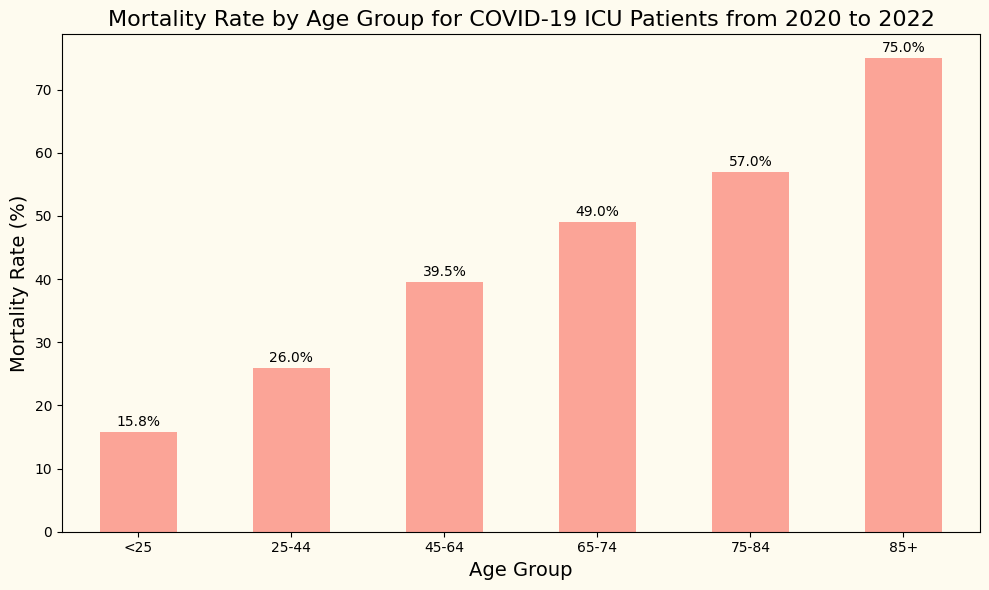

In [197]:
def plot_mortality_by_age_group(covid_diagnoses):
    covid_diagnoses = covid_diagnoses.copy()

    # Calculate mortality rate by age group
    age_mortality = covid_diagnoses.groupby('age_group').agg(
        total_patients=('subject_id', 'nunique'),
        deaths=('is_dead', 'sum')
    )
    age_mortality.loc[:, 'mortality_rate'] = age_mortality['deaths'] / age_mortality['total_patients'] * 100

    # Plotting
    plt.figure(figsize=(10, 6), facecolor='#fefbef')

    age_mortality['mortality_rate'].plot(kind='bar', color='salmon', alpha=0.7)
    plt.title('Mortality Rate by Age Group for COVID-19 ICU Patients from 2020 to 2022', fontsize=16)
    plt.xlabel('Age Group', fontsize=14)
    plt.ylabel('Mortality Rate (%)', fontsize=14)
    plt.xticks(rotation=0)

    # Add value labels on top of bars
    for index, value in enumerate(age_mortality['mortality_rate']):
        plt.text(index, value + 0.5, f'{value:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


# lets filter for 2020 to 2022 year group which is peak of covid
covid_diagnoses_filtered = covid_diagnoses[covid_diagnoses['anchor_year_group'] == '2020 - 2022']
plot_mortality_by_age_group(covid_diagnoses_filtered)

#### Mortality by Insurance Type

Lets investigate the impact of insurance type on mortality rates

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_13222/61525480.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  insurance_mortality = covid_diagnoses.groupby('insurance').agg(


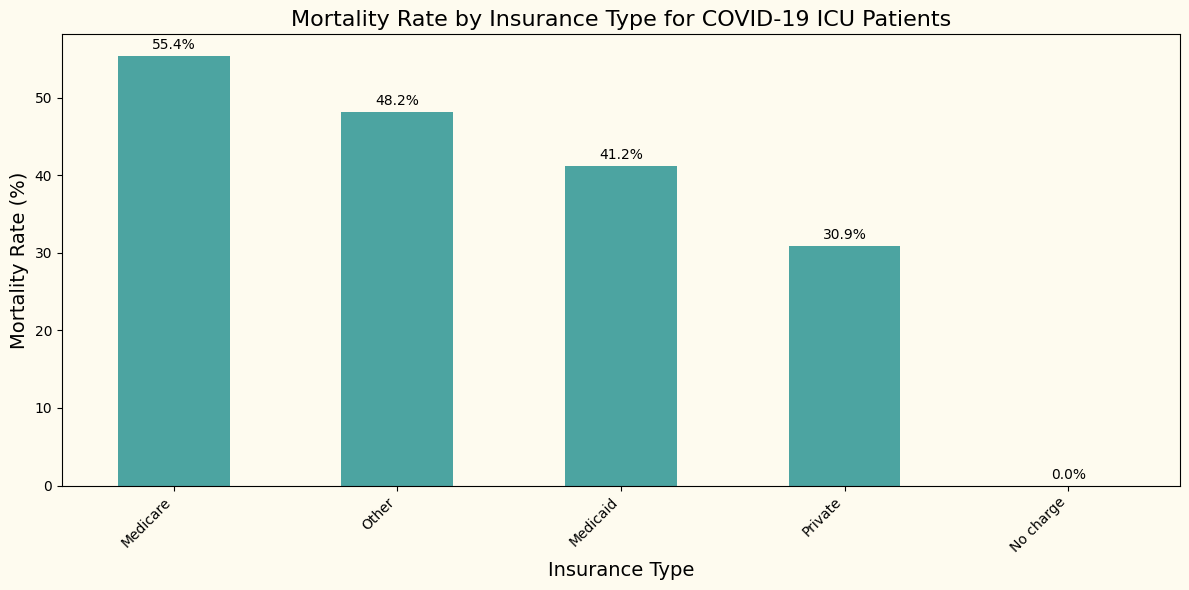

In [198]:
def plot_mortality_by_insurance_type(covid_diagnoses):
    # Calculate mortality rate by insurance type
    insurance_mortality = covid_diagnoses.groupby('insurance').agg(
        total_patients=('subject_id', 'nunique'),
        deaths=('is_dead', 'sum')
    )
    insurance_mortality['mortality_rate'] = insurance_mortality['deaths'] / insurance_mortality['total_patients'] * 100

    # Sort by mortality rate
    insurance_mortality = insurance_mortality.sort_values(by='mortality_rate', ascending=False)

    # Plotting
    plt.figure(figsize=(12, 6), facecolor='#fefbef')
    insurance_mortality['mortality_rate'].plot(kind='bar', color='teal', alpha=0.7)
    plt.title('Mortality Rate by Insurance Type for COVID-19 ICU Patients', fontsize=16)
    plt.xlabel('Insurance Type', fontsize=14)
    plt.ylabel('Mortality Rate (%)', fontsize=14)
    plt.xticks(rotation=45, ha='right')

    # Add value labels
    for index, value in enumerate(insurance_mortality['mortality_rate']):
        plt.text(index, value + 0.5, f'{value:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

plot_mortality_by_insurance_type(covid_diagnoses_filtered)

We can also visualize this using a sankey diagram, which will show the flow of patients in the ICU to either survival or death depending on their insurance coverage

In [240]:
def plot_sankey_mortality_by_insurance_type(covid_diagnoses):
    # Calculate mortality rate by insurance type
    insurance_mortality = covid_diagnoses.groupby('insurance').agg(
        total_patients=('subject_id', 'nunique'),
        deaths=('is_dead', 'sum')
    )
    insurance_mortality['mortality_rate'] = (
        insurance_mortality['deaths'] / insurance_mortality['total_patients'] * 100
    )

    # Prepare data for Sankey diagram
    labels = list(insurance_mortality.index) + ['Survived', 'Deceased']
    sources = []
    targets = []
    values = []

    for index, row in insurance_mortality.iterrows():
        insurance_idx = labels.index(index)
        deceased_idx = labels.index('Deceased')
        survived_idx = labels.index('Survived')

        sources.append(insurance_idx)
        targets.append(deceased_idx)
        values.append(row['deaths'])

        sources.append(insurance_idx)
        targets.append(survived_idx)
        values.append(row['total_patients'] - row['deaths'])

    # Create Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=20,
            thickness=30,
            line=dict(color="black", width=0.5),
            label=labels,
            color="rgba(31, 119, 180, 0.8)"
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=["rgba(255,0,0,0.6)" if label == 'Deceased' else "rgba(0,255,0,0.6)" for label in [labels[t] for t in targets]]
        )
    )])

    fig.update_layout(
        title_text="Mortality and Survival Rates by Insurance Type among COVID-19 ICU Patients",
        font=dict(size=14, color='black'),
        paper_bgcolor='#fefbef',
        plot_bgcolor='#fefbef',
        margin=dict(l=50, r=50, t=100, b=50),
        height = 600
    )
    fig.show()

plot_sankey_mortality_by_insurance_type(covid_diagnoses_filtered)

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_13222/3018916664.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



#### Heatmap of Mortality Rates

Lets visualize the mortality rates by year group and age groups

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_13222/886092180.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = covid_diagnoses.groupby(['anchor_year_group', 'age_group']).agg(


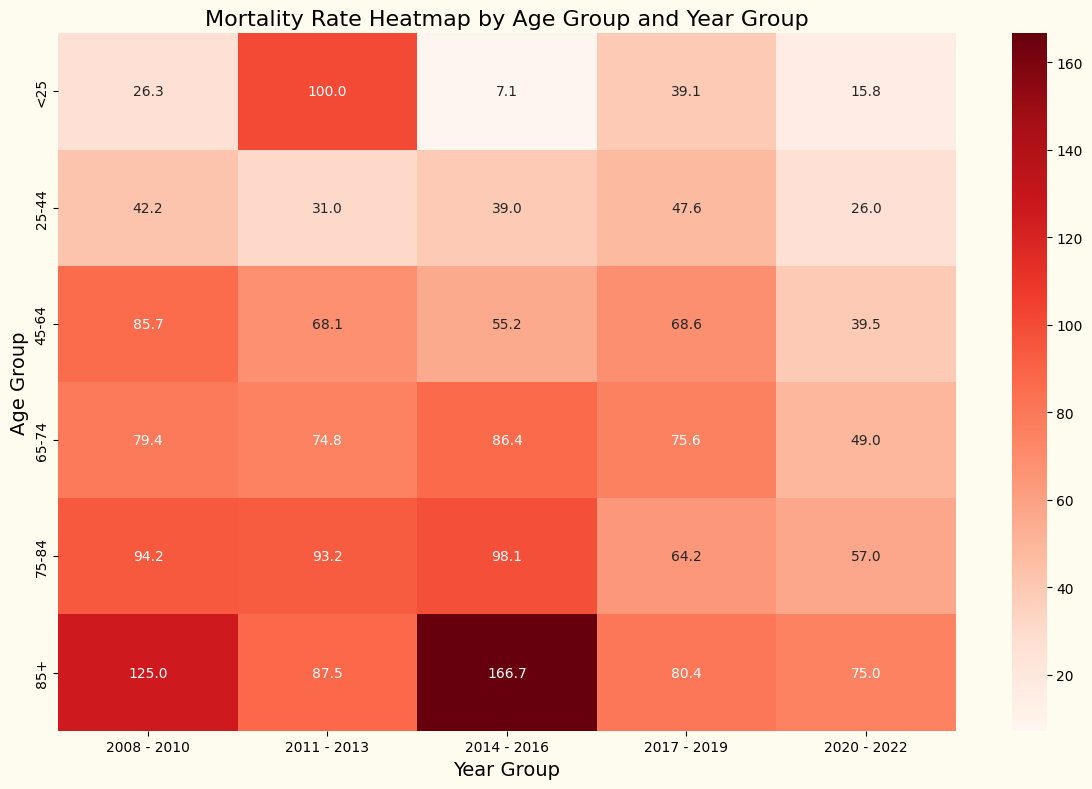

In [199]:
def plot_mortality_heatmap(covid_diagnoses):
    # Calculate mortality rate by age group and year group
    heatmap_data = covid_diagnoses.groupby(['anchor_year_group', 'age_group']).agg(
        total_patients=('subject_id', 'nunique'),
        deaths=('is_dead', 'sum')
    )
    heatmap_data['mortality_rate'] = heatmap_data['deaths'] / heatmap_data['total_patients'] * 100

    # Pivot the data for the heatmap
    heatmap_pivot = heatmap_data.reset_index().pivot(
        index='age_group',
        columns='anchor_year_group',
        values='mortality_rate'
    )

    # Sorting indices and columns
    heatmap_pivot = heatmap_pivot.sort_index()
    heatmap_pivot = heatmap_pivot[sorted(heatmap_pivot.columns, key=lambda x: int(x.split(' - ')[0]))]

    # Plotting
    plt.figure(figsize=(12, 8), facecolor='#fefbef')
    sns.heatmap(heatmap_pivot, annot=True, fmt=".1f", cmap='Reds')
    plt.title('Mortality Rate Heatmap by Age Group and Year Group', fontsize=16)
    plt.xlabel('Year Group', fontsize=14)
    plt.ylabel('Age Group', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_mortality_heatmap(covid_diagnoses)

It is interesting to note that the mortality rates are lower in 2020-2022 compared to the previous years. Looking at the mortality rates of some age groups, we see that they mortality rate is incredible higher.

This could be attributed to the fact the mortality rate of COVID-19 in the US was around 2.5%. Thus even though the number of admissions to the ICU increased in 2020-2022 and the number of deaths increased, the mortality rate dropped. We must remember that we are looking at the ICU patients, thus these are the subsample of the population who got covid that had the most severe symptoms and cases. Even then, the mortality rate was lower than many of the previous new communicable diseases (which represent the patients with the same codes before 2020).

## Demographic Comparisons

Lets compare the demographics of the patients with COVID to the patients without COVID diagonsis.

First we need to isolate the patients without a COVID diagnosis code

In [200]:
# filter out patients with covid-19 diagnoses codes
non_covid_diagnoses = diagnosis_icu_df[~diagnosis_icu_df['icd_code'].str.contains(covid_pattern, regex=True, na=False)].copy()
# Create age groups for non-COVID-19 patients
non_covid_diagnoses.loc[:, 'age_group'] = pd.cut(non_covid_diagnoses['anchor_age'], 
                                          bins=[0, 25, 45, 65, 75, 85, 100],
                                          labels=['<25', '25-44', '45-64', '65-74', '75-84', '85+'])


/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_13222/3534856190.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  non_covid_diagnoses = diagnosis_icu_df[~diagnosis_icu_df['icd_code'].str.contains(covid_pattern, regex=True, na=False)].copy()


#### Age Distribution Comparison

- Compare age distributions between COVID-19 patients and non-COVID-19 patients.

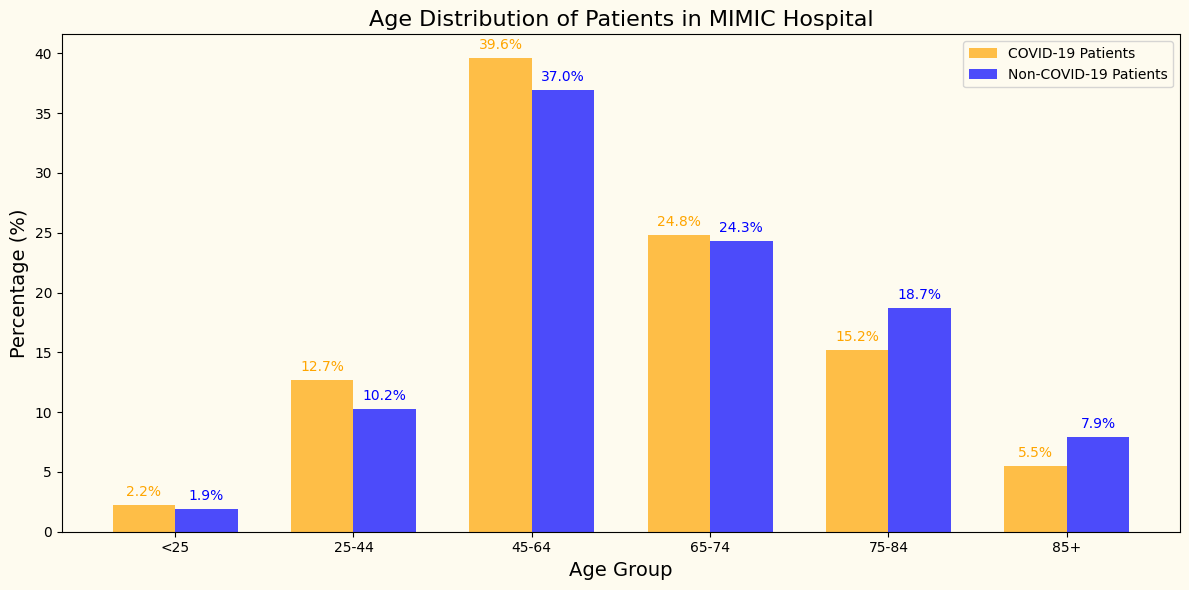

In [201]:
def plot_age_distribution(covid_diagnoses, non_covid_diagnoses):
    # Calculate the percentage distribution for COVID-19 patients
    age_distribution = covid_diagnoses['age_group'].value_counts(normalize=True).sort_index() * 100
    # Calculate the percentage distribution for non-COVID-19 patients
    non_covid_age_distribution = non_covid_diagnoses['age_group'].value_counts(normalize=True).sort_index() * 100

    # Plotting
    plt.figure(figsize=(12, 6), facecolor='#fefbef')
    plt.rcParams['axes.facecolor'] = '#fefbef'  # Set background color
    bar_width = 0.35
    index = np.arange(len(age_distribution))

    # Plot COVID-19 patients
    plt.bar(index, age_distribution, bar_width, label='COVID-19 Patients', color='orange', alpha=0.7)

    # Plot non-COVID-19 patients
    plt.bar(index + bar_width, non_covid_age_distribution, bar_width, label='Non-COVID-19 Patients', color='blue', alpha=0.7)

    plt.title('Age Distribution of Patients in MIMIC Hospital', fontsize=16)
    plt.xlabel('Age Group', fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=14)
    plt.xticks(index + bar_width / 2, age_distribution.index, rotation=0)
    plt.legend()

    # Add percentage labels on top of each bar
    for i, v in enumerate(age_distribution):
        plt.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom', color='orange')
    for i, v in enumerate(non_covid_age_distribution):
        plt.text(i + bar_width, v + 0.5, f'{v:.1f}%', ha='center', va='bottom', color='blue')

    plt.tight_layout()
    plt.show()

plot_age_distribution(covid_diagnoses, non_covid_diagnoses)


#### Insurance Distribution Comparison

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_13222/3275789235.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  covid_insurance_counts = covid_diagnoses.groupby('insurance').size().sort_values(ascending=False)
/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_13222/3275789235.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  non_covid_insurance_counts = non_covid_diagnoses.groupby('insurance').size().sort_values(ascending=False)


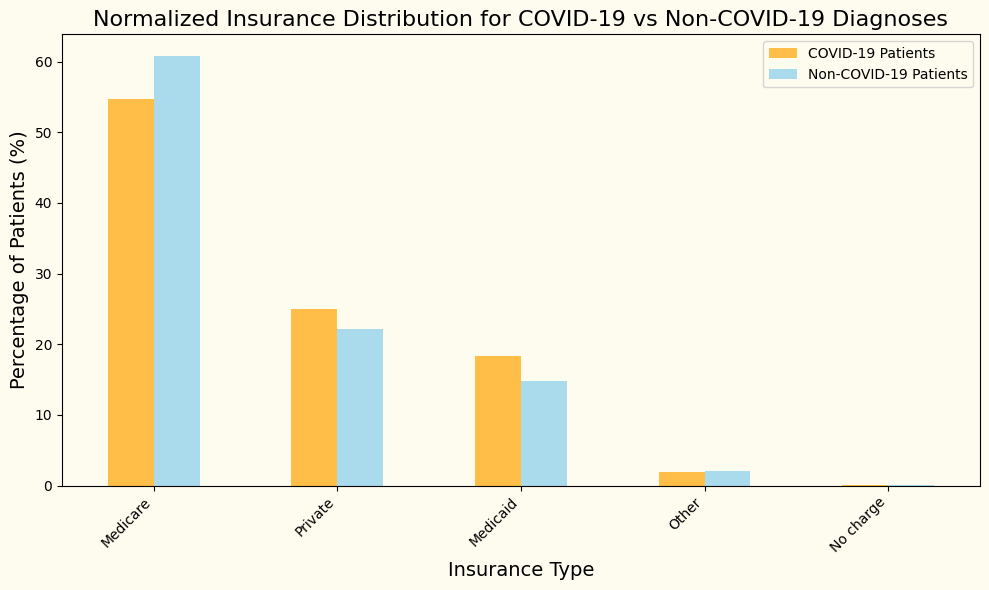

In [202]:
def plot_insurance_distribution(covid_diagnoses, non_covid_diagnoses):
    # Calculate insurance counts for COVID-19 diagnoses
    covid_insurance_counts = covid_diagnoses.groupby('insurance').size().sort_values(ascending=False)
    # Calculate insurance counts for non-COVID-19 diagnoses
    non_covid_insurance_counts = non_covid_diagnoses.groupby('insurance').size().sort_values(ascending=False)

    # Combine the counts into a DataFrame
    insurance_counts = pd.DataFrame({
        'COVID-19 Patients': covid_insurance_counts,
        'Non-COVID-19 Patients': non_covid_insurance_counts
    }).fillna(0)

    # Normalize the counts
    insurance_counts['COVID-19 Patients'] = insurance_counts['COVID-19 Patients'] / insurance_counts['COVID-19 Patients'].sum() * 100
    insurance_counts['Non-COVID-19 Patients'] = insurance_counts['Non-COVID-19 Patients'] / insurance_counts['Non-COVID-19 Patients'].sum() * 100

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='#fefbef')
    insurance_counts.plot(kind='bar', ax=ax, color=['orange', 'skyblue'], alpha=0.7)

    # Title and labels
    ax.set_title('Normalized Insurance Distribution for COVID-19 vs Non-COVID-19 Diagnoses', fontsize=16)
    ax.set_xlabel('Insurance Type', fontsize=14)
    ax.set_ylabel('Percentage of Patients (%)', fontsize=14)

    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

plot_insurance_distribution(covid_diagnoses, non_covid_diagnoses)

#### Gender Distribution Comparison

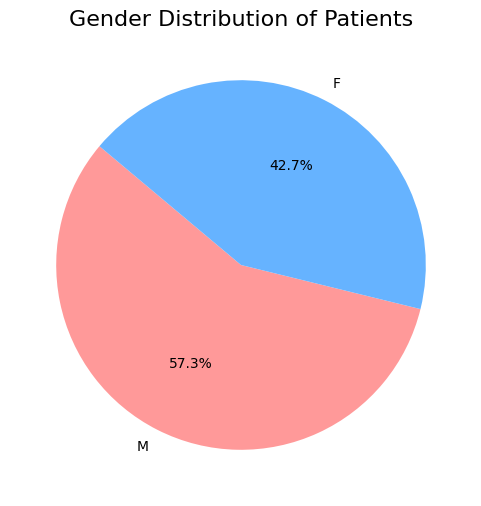

In [203]:
# pie chart 
gender_counts = covid_diagnoses['gender'].value_counts()
plt.figure(figsize=(6, 6))
gender_counts.plot.pie(autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Gender Distribution of Patients', fontsize=16)
plt.ylabel('')
plt.show()

#### ICU Admissions Over Time 

Analyze the propotion of ICU admissions attributed to COVID-19's ICD codes over time. To reiterate, the patients with these codes before the pandemic are individuals who were admitted for contact with communicable infectious diseases or novel diseases. It is important to remember that Covid-19 was a global pandemic for a reason

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_13222/1609679766.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  covid_counts = covid_diagnoses.groupby('anchor_year_group')['subject_id'].nunique().reset_index()
/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_13222/1609679766.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  non_covid_counts = non_covid_diagnoses.groupby('anchor_year_group')['subject_id'].nunique().reset_index()


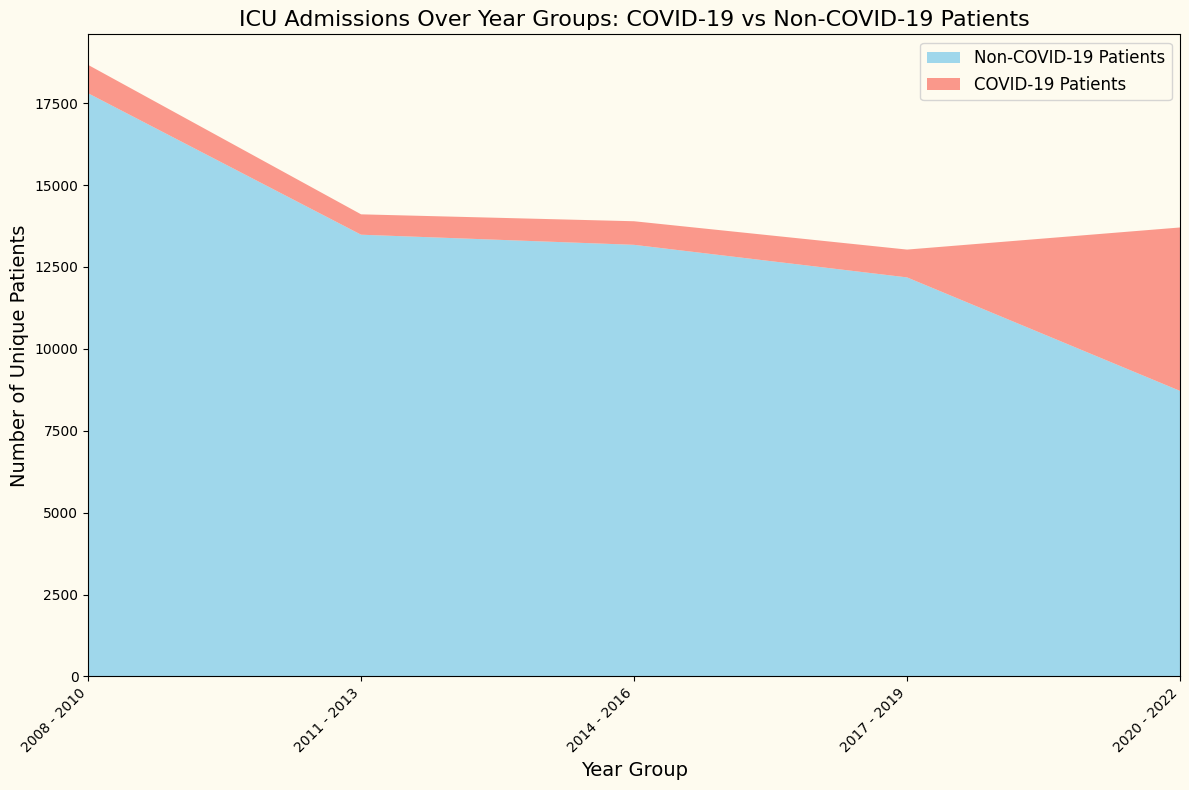

In [204]:
def analyze_icu_admissions(covid_diagnoses, non_covid_diagnoses):
    # Group and count unique patients
    covid_counts = covid_diagnoses.groupby('anchor_year_group')['subject_id'].nunique().reset_index()
    covid_counts.rename(columns={'subject_id': 'covid_patients'}, inplace=True)

    non_covid_counts = non_covid_diagnoses.groupby('anchor_year_group')['subject_id'].nunique().reset_index()
    non_covid_counts.rename(columns={'subject_id': 'non_covid_patients'}, inplace=True)

    # Merge counts
    patient_counts = pd.merge(covid_counts, non_covid_counts, on='anchor_year_group', how='outer')
    patient_counts['total_patients'] = patient_counts['covid_patients'] + patient_counts['non_covid_patients']

    # Sort by year group
    patient_counts = patient_counts.sort_values(by='anchor_year_group', key=lambda x: x.str.split(' - ').str[0].astype(int))

    def plot_icu_admissions(patient_counts):
        """
        Plots an area chart of ICU admissions over year groups for COVID-19 vs Non-COVID-19 patients.

        Parameters:
        - patient_counts (DataFrame): A DataFrame containing columns 'anchor_year_group', 'non_covid_patients', and 'covid_patients'.
        """
        # Plot the area chart
        plt.figure(figsize=(12, 8), facecolor='#fefbef')

        plt.stackplot(
            patient_counts['anchor_year_group'],
            patient_counts['non_covid_patients'],
            patient_counts['covid_patients'],
            labels=['Non-COVID-19 Patients', 'COVID-19 Patients'],
            colors=['skyblue', 'salmon'],
            alpha=0.8
        )

        # removing the margins on the x-axis
        plt.margins(x=0)

        # Titles and labels
        plt.title('ICU Admissions Over Year Groups: COVID-19 vs Non-COVID-19 Patients', fontsize=16)
        plt.xlabel('Year Group', fontsize=14)
        plt.ylabel('Number of Unique Patients', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.legend(loc='upper right', fontsize=12)
        plt.tight_layout()
        plt.show()

    plot_icu_admissions(patient_counts)

analyze_icu_admissions(covid_diagnoses, non_covid_diagnoses)

## Comparison with External Data

We can use the Medicare Montly Enrollment Data to compare the COVID-19 incidence at the Beth-Isreal Hospital with the local area, which is suffolk county.

In [205]:
# load suffolk_df
suffolk_df = pd.read_pickle("../Processed_Data/suffolk_df.pkl")

#### Medicare Beneficiaries Analysis

- Import and analyze age distribution data of Medicare beneficaries in Suffolk County, compare with the age distribution of MIMIC COVID-19 patients.

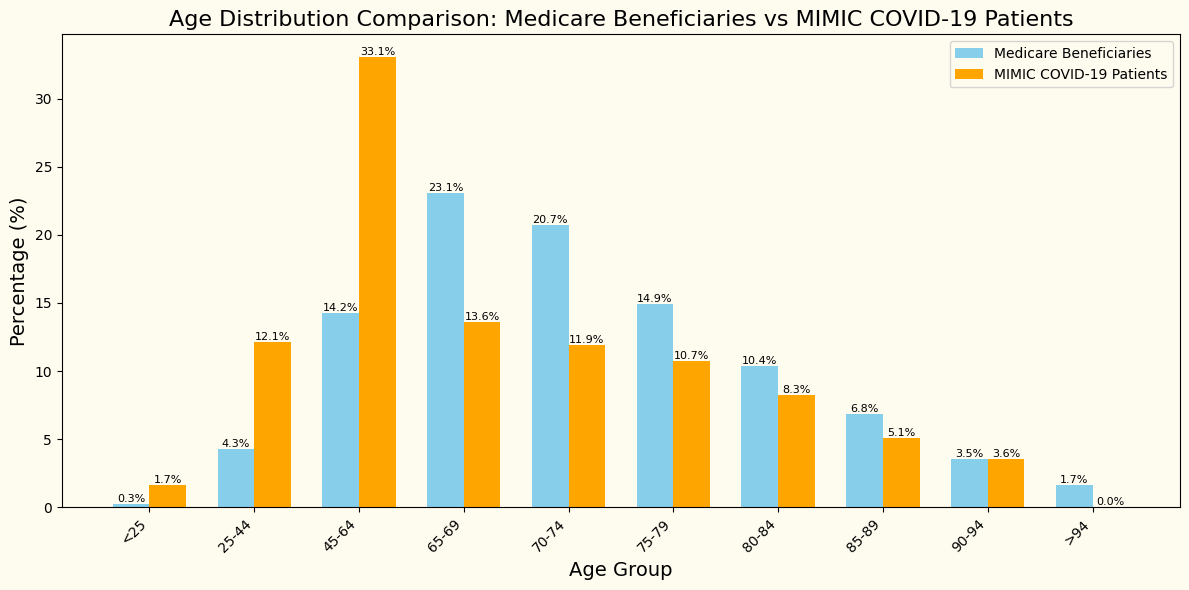

In [243]:
def plot_age_distribution_comparison(suffolk_df, covid_diagnoses):
    """
    Plots a comparison of age distribution between Medicare Beneficiaries and MIMIC COVID-19 Patients.

    Parameters:
    - suffolk_df (DataFrame): DataFrame containing age distribution data for Medicare Beneficiaries.
    - covid_diagnoses (DataFrame): DataFrame containing COVID-19 patient data with 'anchor_age' column.
    """
    # Age Distribution Analysis for Medicare Beneficiaries
    age_columns = [
        'AGE_LT_25_BENES', 'AGE_25_TO_44_BENES', 'AGE_45_TO_64_BENES',
        'AGE_65_TO_69_BENES', 'AGE_70_TO_74_BENES', 'AGE_75_TO_79_BENES',
        'AGE_80_TO_84_BENES', 'AGE_85_TO_89_BENES', 'AGE_90_TO_94_BENES',
        'AGE_GT_94_BENES'
    ]

    age_distribution_medicare = suffolk_df[age_columns].sum()
    total_beneficiaries = age_distribution_medicare.sum()
    age_percentages_medicare = (age_distribution_medicare / total_beneficiaries * 100).round(2)

    # Friendly labels for visualization
    age_labels = [
        '<25', '25-44', '45-64', '65-69', '70-74', '75-79',
        '80-84', '85-89', '90-94', '>94'
    ]

    age_percentages_medicare.index = age_labels

    # For COVID-19 patients
    bins = [0, 25, 45, 65, 70, 75, 80, 85, 90, 95, 150]
    covid_diagnoses['age_group'] = pd.cut(covid_diagnoses['anchor_age'], bins=bins, labels=age_labels, right=False)

    age_distribution_covid = covid_diagnoses['age_group'].value_counts().sort_index()
    total_covid_patients = age_distribution_covid.sum()
    age_percentages_covid = (age_distribution_covid / total_covid_patients * 100).round(2)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6), facecolor='#fefbef')

    x = range(len(age_labels))
    width = 0.35

    ax.bar([i - width/2 for i in x], age_percentages_medicare, width, label='Medicare Beneficiaries', color='skyblue')
    ax.bar([i + width/2 for i in x], age_percentages_covid, width, label='MIMIC COVID-19 Patients', color='orange')

    ax.set_ylabel('Percentage (%)', fontsize=14)
    ax.set_xlabel('Age Group', fontsize=14)
    ax.set_title('Age Distribution Comparison: Medicare Beneficiaries vs MIMIC COVID-19 Patients', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(age_labels, rotation=45, ha='right')
    ax.legend()

    # Add percentage labels on top of each bar
    for i, v in enumerate(age_percentages_medicare):
        ax.text(i - width/2, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=8)
    for i, v in enumerate(age_percentages_covid):
        ax.text(i + width/2, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

# Assuming suffolk_df and covid_diagnoses are already loaded
plot_age_distribution_comparison(suffolk_df, covid_diagnoses_filtered)

## Prescription Patterns in COVID-19 Patients

#### Loading Prescription Data

In [207]:
prescriptions_table = pd.read_pickle("../Processed_Data/prescriptions.pkl")

Utils.print_info(prescriptions_table)


DataFrame Information for: Unnamed DataFrame

Shape:
  Rows: 20292611, Columns: 7

Column Types:
  int64: 2
  object: 2
  category: 1
  category: 1
  float64: 1

Missing Values:
  drug: 1 (0.00%)
  gsn: 2407028 (11.86%)
  ndc: 33456 (0.16%)
  prod_strength: 9398 (0.05%)

Numeric Columns Summary:
         subject_id       hadm_id           ndc
count  2.029261e+07  2.029261e+07  2.025916e+07
mean   1.500704e+07  2.500108e+07  1.771826e+10
std    2.883361e+06  2.885402e+06  2.650798e+10
min    1.000003e+07  2.000002e+07  0.000000e+00
25%    1.251397e+07  2.250350e+07  1.725729e+08
50%    1.500679e+07  2.500749e+07  4.879801e+08
75%    1.751464e+07  2.749326e+07  5.026806e+10
max    1.999999e+07  2.999993e+07  9.920702e+10

Categorical Columns Summary:
  drug_type:
    Unique values: 3
    Top 5 values: {'MAIN': 16791812, 'BASE': 3471112, 'ADDITIVE': 29687}
  drug:
    Unique values: 10926
    Top 5 values: {'Insulin': 845166, '0.9% Sodium Chloride': 728089, 'Potassium Chloride': 674552, 

,subject_id,hadm_id,drug_type,drug,gsn,ndc,prod_strength
0,10000032,22595853,MAIN,Furosemide,008209,5.107901e+10,40mg Tablet
1,10000032,22595853,MAIN,Ipratropium Bromide Neb,021700,4.879801e+08,2.5mL Vial
2,10000032,22595853,MAIN,Furosemide,008208,5.107901e+10,20mg Tablet
3,10000032,22595853,MAIN,Potassium Chloride,001275,2.450041e+08,10mEq ER Tablet
4,10000032,22595853,MAIN,Sodium Chloride 0.9% Flush,NaN,0.000000e+00,10 mL Syringe


In [208]:
# merge with covid_diagnosis population
covid_prescriptions = covid_diagnoses.merge(prescriptions_table, on=['subject_id', 'hadm_id'], how='inner')
covid_prescriptions.head(3)

,subject_id,hadm_id,icd_code,icd_version,category_code,category,subcategory,stay_id,first_careunit,last_careunit,...,edouttime,hospital_expire_flag,admission_los_hours,covid_category,age_group,drug_type,drug,gsn,ndc,prod_strength
0,10002114,27793700,Z20822,10,Z20,Health Factors & Services,Persons with potential health hazards related ...,34672098,Coronary Care Unit (CCU),Coronary Care Unit (CCU),...,2162-02-17 23:30:00,0,352.733333,Suspected,45-64,BASE,Iso-Osmotic Sodium Chloride,NaN,0.000000e+00,100mL Bag
1,10002114,27793700,Z20822,10,Z20,Health Factors & Services,Persons with potential health hazards related ...,34672098,Coronary Care Unit (CCU),Coronary Care Unit (CCU),...,2162-02-17 23:30:00,0,352.733333,Suspected,45-64,MAIN,Calcium Gluconate,079278,4.456706e+10,2 g / 100 mL Premix Bag
2,10002114,27793700,Z20822,10,Z20,Health Factors & Services,Persons with potential health hazards related ...,34672098,Coronary Care Unit (CCU),Coronary Care Unit (CCU),...,2162-02-17 23:30:00,0,352.733333,Suspected,45-64,MAIN,Heparin,006549,2.502104e+10,5000 Units / mL- 1mL Vial


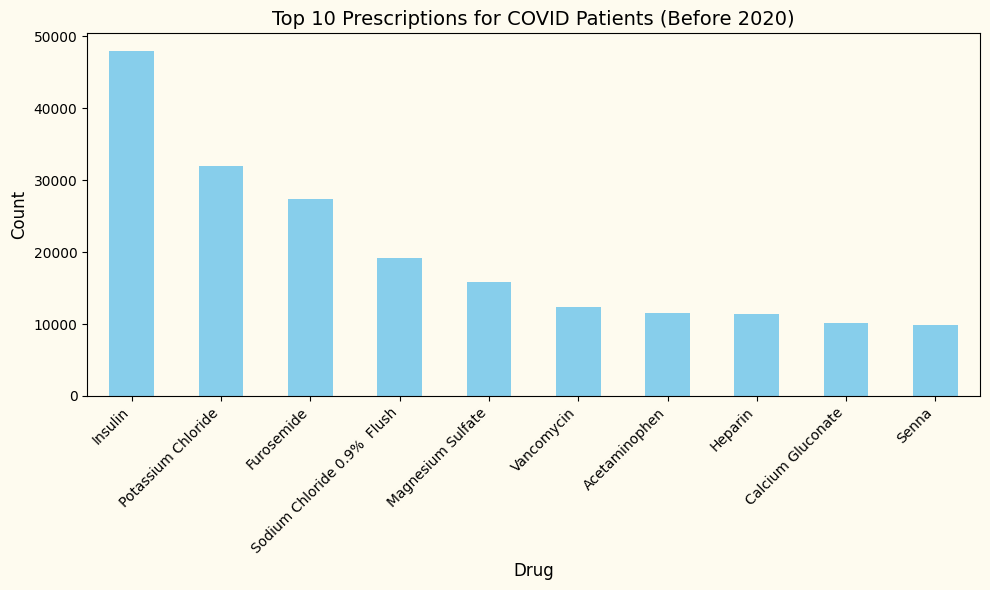

In [209]:
def plot_top10_drugs(covid_prescriptions):
    top10_drugs = covid_prescriptions.query("drug_type == 'MAIN' & anchor_year_group != '2020 - 2022'").drug.value_counts().head(10)
    
    plt.figure(figsize=(10, 6), facecolor='#fefbef')
    ax = plt.gca()
    ax.set_facecolor('#fefbef')
    top10_drugs.plot.bar(color='skyblue')
    plt.title('Top 10 Prescriptions for COVID Patients (Before 2020)', fontsize=14)
    plt.xlabel('Drug', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_top10_drugs(covid_prescriptions)

#### Exploring Common Medications

- Identify the most commonly prescribed drugs to COVID-19 patients

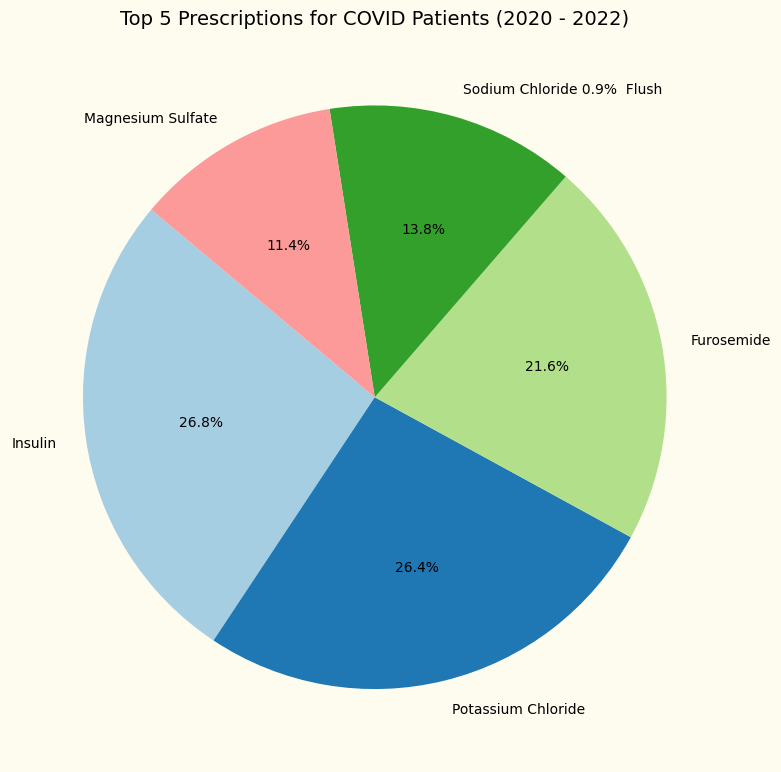

In [210]:
top5_drugs = covid_prescriptions.query("drug_type == 'MAIN' & anchor_year_group == '2020 - 2022'")['drug'].value_counts().head(5)

plt.figure(figsize=(8, 8), facecolor='#fefbef')
top5_drugs.plot.pie(autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Top 5 Prescriptions for COVID Patients (2020 - 2022)', fontsize=14)
plt.ylabel('')
plt.tight_layout()
plt.show()

#### Antiviral Medication Analysis

- Focus on specific antiviral medications prescribed and analyze trends over time.

Antiviral Medications
Paxlovid (nirmatrelvir/ritonavir)
NDC: 00069108506
NDC: 00069108530
NDC: 00069110120
NDC: 00069110104
NDC: 00069034530
NDC: 00069034506
Remdesivir (Veklury)
No specific NDC provided in the search results
Molnupiravir (Lagevrio)
NDC: 00006505506
NDC: 00006505507

In [211]:
# Define the NDC codes we're looking for
ndc_codes = [
    '00069108506', '00069108530', '00069110120', '00069110104', 
    '00069034530', '00069034506', '00006505506', '00006505507'
]

# Convert NDC codes to the same format as in the DataFrame (assuming they're stored as floats)
ndc_codes_float = [float(code) for code in ndc_codes]

# Filter the DataFrame for matching NDC codes
covid_antiviral_prescriptions = covid_prescriptions[covid_prescriptions['ndc'].isin(ndc_codes_float)]

# Display the results
print(f"Found {len(covid_antiviral_prescriptions)} prescriptions matching the specified NDC codes.")
print(covid_antiviral_prescriptions[['subject_id', 'hadm_id', 'drug', 'ndc', 'prod_strength']])

# Count occurrences of each drug
drug_counts = covid_antiviral_prescriptions['drug'].value_counts()
print("\nDrug counts:")
print(drug_counts)

# Check for Remdesivir by drug name (since NDC wasn't provided)
remdesivir_prescriptions = covid_prescriptions[covid_prescriptions['drug'].str.contains('Remdesivir', case=False, na=False)]
print(f"\nFound {len(remdesivir_prescriptions)} prescriptions for Remdesivir.")
print(remdesivir_prescriptions[['subject_id', 'hadm_id', 'drug', 'ndc', 'prod_strength']])

Found 18 prescriptions matching the specified NDC codes.
         subject_id   hadm_id                          drug         ndc  \
198765     11064975  21841886  Nirmatrelvir-Ritonavir (EUA)  69108530.0   
198791     11064975  21841886  Nirmatrelvir-Ritonavir (EUA)  69108530.0   
198926     11064975  21841886  Nirmatrelvir-Ritonavir (EUA)  69108530.0   
215849     11168241  21430249  Nirmatrelvir-Ritonavir (EUA)  69108530.0   
946830     15168081  22611123  Nirmatrelvir-Ritonavir (EUA)  69108530.0   
983193     15352109  23759831  Nirmatrelvir-Ritonavir (EUA)  69108530.0   
1144661    16179209  29791511  Nirmatrelvir-Ritonavir (EUA)  69108530.0   
1418539    17713219  23018295  Nirmatrelvir-Ritonavir (EUA)  69108530.0   
1418555    17713219  23018295  Nirmatrelvir-Ritonavir (EUA)  69108530.0   
1418556    17713219  23018295  Nirmatrelvir-Ritonavir (EUA)  69108530.0   
1418581    17713219  23018295  Nirmatrelvir-Ritonavir (EUA)  69108530.0   
1418598    17713219  23018295  Nirmatrelvir

/var/folders/l5/2h1t38ld23b0fmqx49g_q67c0000gn/T/ipykernel_13222/3305285579.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_prescriptions = all_antiviral_prescriptions.groupby('anchor_year_group').size().sort_index()


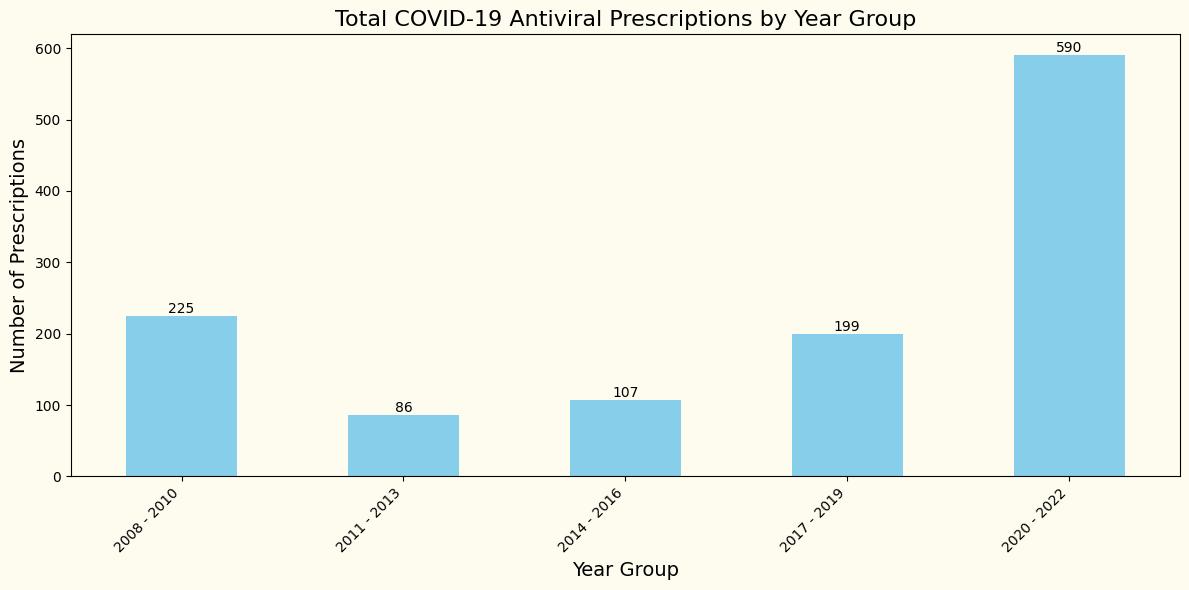

In [212]:
def plot_total_antiviral_prescriptions(covid_antiviral_prescriptions, remdesivir_prescriptions):
    # Combine antiviral prescriptions
    all_antiviral_prescriptions = pd.concat([covid_antiviral_prescriptions, remdesivir_prescriptions])

    # Group by anchor_year_group and count total prescriptions
    total_prescriptions = all_antiviral_prescriptions.groupby('anchor_year_group').size().sort_index()

    # Create a bar chart
    plt.figure(figsize=(12, 6), facecolor='#fefbef')
    ax = total_prescriptions.plot(kind='bar', color='skyblue')
    ax.set_facecolor('#fefbef')

    plt.title('Total COVID-19 Antiviral Prescriptions by Year Group', fontsize=16)
    plt.xlabel('Year Group', fontsize=14)
    plt.ylabel('Number of Prescriptions', fontsize=14)
    plt.xticks(rotation=45, ha='right')

    # Add value labels on the bars
    for i, v in enumerate(total_prescriptions):
        ax.text(i, v, str(v), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Call the function with the appropriate arguments
plot_total_antiviral_prescriptions(covid_antiviral_prescriptions, remdesivir_prescriptions)

## Conclusions

### Summary of Findings

In this analysis of ICU patients diagnosed with COVID-19 using the MIMIC database, we have uncovered several key insights:

- **ICU Admission Trends**: There was a noticeable increase in ICU admissions for COVID-19 patients during the peak periods of the pandemic. This trend highlights the significant strain placed on healthcare systems during these times.

- **Mortality Rates**: Mortality rates among COVID-19 patients varied significantly by age group, with older patients experiencing higher mortality rates. Additionally, insurance type appeared to have an impact on patient outcomes, suggesting potential disparities in healthcare access or quality.

- **Demographic Comparisons**: COVID-19 ICU patients tended to be older compared to non-COVID-19 ICU patients. Gender distribution analysis revealed a slightly higher proportion of male patients in the COVID-19 group.

- **Prescription Patterns**: Antiviral medications, particularly Remdesivir, were commonly prescribed to COVID-19 patients. The analysis of prescription trends over time provided insights into the evolving treatment protocols during the pandemic.

- **External Data Comparison**: When comparing the age distribution of MIMIC COVID-19 patients with Medicare beneficiaries in Suffolk County, we observed similar age trends, reinforcing the representativeness of the MIMIC dataset.

### Limitations

While this analysis provides valuable insights, it is important to acknowledge certain limitations:

- **Data Scope**: The analysis is limited to the MIMIC database, which may not fully represent all ICU settings or patient populations.

- **ICD Code Limitations**: The reliance on ICD codes for identifying COVID-19 cases may lead to misclassification, especially in the early stages of the pandemic when testing was limited.

- **External Data Comparisons**: The external dataset used for comparison may have its own biases and limitations, affecting the generalizability of the findings.

### Recommendations

Based on our findings, we suggest the following:

- **Further Research**: Additional studies should explore the impact of socioeconomic factors on COVID-19 outcomes, as well as the long-term effects of ICU treatment on patient recovery.

- **Policy Implications**: Healthcare policymakers should consider the disparities in outcomes based on insurance type and work towards ensuring equitable access to care.

- **Data Collection Improvements**: Future data collection efforts should aim to capture more comprehensive information on patient demographics and treatment protocols to enhance the quality of analyses.

By addressing these areas, we can continue to improve our understanding of COVID-19's impact on ICU patients and develop more effective strategies for managing future public health crises.